# Algoritmo de detección de carriles usando visión


En lo siguiente se presenta una explicación detallada de los procedimientos utilizados para la detección de carriles en el algoritmo implementado en el vehículo eléctrico. (v.e.)

El algoritmo aquí presentado utiliza las librerias OpenCV, NumPy, math, para el desarrollo de funciones para la detección de carriles de nuestra aplicación. Estas están contenidas en la libreria Lane_functions. 

In [1]:
import cv2
import numpy
import matplotlib.pyplot as plt
import math
import Lane_functions  #Contiene las funciones para detectar carriles

El v.e. está configurado para recibir imágenes rgb (320x240) de la cámara realsense sr300 a una frecuencia de 10Hz. Dicha resolución se seleccionó debido a que el algoritmo aquí presente tiene un tiempo de ejecución menor a 100 ms al procesar imagenes rgb de 320x240. Se ha comprobado que con imagenes de mayor resolución el algoritmo no puede procesar las imagenes a esa frecuencia.

La variable "state" representa el estado en el que se encontraba el vehículo en el paso anterior. Como en este ejemplo no se están analizando imagenes continuamente se supone un estado inicial "state=1" que significa que en la última imagen procesada se pudieron detectar los dos carriles. Más adelante se detallarán cada uno de los estados así como la posible evolución entre ellos.

En esta parte sólo se toma una imagen de una de las pruebas realizadas en el auditorio y se redimensiona a 320x240.

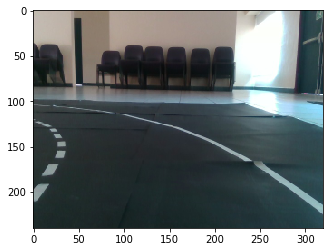

In [2]:
state = 1
cv_image = plt.imread('BE_Lane_data/Auditorio/left0007.jpg')   
#cv_image = plt.imread('BE_Lane_data/center.jpg')    #CALIBRACION   
#En el V.E. se obtendrán imagenes de 320x240 para tener un
#procesamiento más rápido
cv_image = cv2.resize(cv_image, (320,240))                 
plt.imshow(cv_image)  

A partir de este punto lo que se debe hacer es procesar la imagen para obtener una imagen binaria que contenga sólo los bordes de presentes en la imagen. ¿Porqué nos interesan los bordes? Porque algunos de ellos representan los carriles.

El procedimiento es sencillo:
    
    1) Se convierte la imagen a blanco y negro
    2) Se difumina para eliminar ruido (cv2.GaussianBlur)
    3) Se utiliza la función cv2.Canny para encontrar los bordes en la imagen. La sensibilidad se puede ajustar modificando los parámetros minThreshold y maxThreshold. 

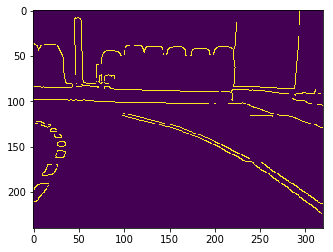

In [3]:
#Conversión a blanco y negro
gray = cv2.cvtColor(cv_image,cv2.COLOR_BGR2GRAY)    

#Eliminar Ruido
kernelSize = 5
blur1 = cv2.GaussianBlur(gray,(kernelSize,kernelSize),0) 

#Detectar bordes 
minThreshold = 120
maxThreshold = 200
edge = cv2.Canny(blur1,minThreshold,maxThreshold)  
plt.imshow(edge)  

A continuación se puede ver un ejemplo de porque es necesario ajustar adecuadamente los parámetros de la detección de bordes para el ambiente en el cual se estará trabajando. En el primer caso con límites bajos la función se configura con una sensibilidad muy alta por lo que detecta mucha información que no nos interesa. En el segundo caso es lo contrario, los límites son tan altos que la función detecta muy poca información.

Text(0.5,1,u'Baja sensibilidad')

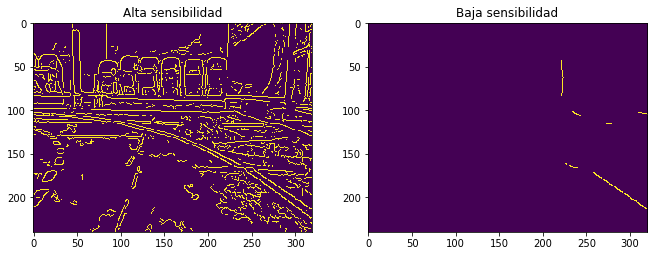

In [14]:
#EXTRA, esto no está contenido en el código implementado
#Sólo un ejemplo para ver la importancia de los límites en la función Canny

#Límites bajos
minThreshold = 0
maxThreshold = 10
bad_edge = cv2.Canny(blur1,minThreshold,maxThreshold) #Detectar esquinas
#Límites ALTOS
minThreshold2 = 320
maxThreshold2 = 400
bad_edge2 = cv2.Canny(blur1,minThreshold2,maxThreshold2) #Detectar esquinas 

plt.figure(figsize=(11,11))

plt.subplot(1,2,1)
plt.imshow(bad_edge)
plt.title('Alta sensibilidad')
plt.subplot(1,2,2)
plt.imshow(bad_edge2)
plt.title('Baja sensibilidad')


La imagen previa se "suaviza" utilizando de nuevo la función GaussianBlur para darle continuidad a los pixeles de los bordes.

Evidentemente la variable kernelSize también se debe escoger de manera adecuada, de tal manera que se cumpla con el objetivo sin obtener una imagen muy difusa de la cual no sea posible obtener la información necesaria.

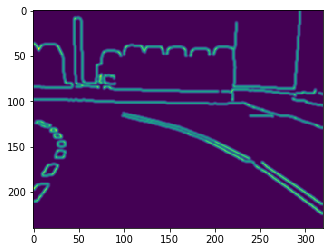

In [5]:
#Eliminación de ruido y continuidad de lineas
blur2 = cv2.GaussianBlur(edge,(kernelSize,kernelSize),0) 
plt.imshow(blur2)

Una suposición útil para disminuir el tiempo en que se procesan las imágenes es que los carriles sólo pueden aparecer en la mitad inferior de la imagen. Es decir, que la parte superior puede ser descartada.

Para llevar a cabo esto se establece una "región de interes" (ROI) y se procede a "enmascarar" la imagen original, i.e., eliminar toda la información fuera de nuestra ROI.


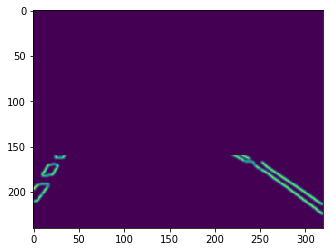

In [6]:
#Establecer el las esquinas del rectangulo considerado como ROI
lowerLeftPoint = [0, 240]
upperLeftPoint = [0,160]
upperRightPoint = [320,160]
lowerRightPoint = [320,240]
#Notar que no se utiliza la mitad inferior completa, sólo una fracción.
pts = numpy.array([[lowerLeftPoint,upperLeftPoint,
                    upperRightPoint,lowerRightPoint]], dtype=numpy.int32)

#Función para obtener la región de interes
masked_image = Lane_functions.region_of_interest(blur2,pts)
plt.imshow(masked_image)

A continuación se procede a obtener una vista aerea de la imagen. ¿Para qué sirve esto? Es bien sabido que en una imagen, debido a la profundidad de la misma, las distancia entre dos lineas, paralelas en el mundo real, no permanece constante. Es decir, que es difícil identificar distancias utilizando únicamente posiciones en pixeles. Tener la imagen en vista aerea es útil para poder tener una aproximación directa entre pixeles/cm.

A continuación se presenta la imagen prueba de la cual se obtuvieron los puntos para obtener la matriz de transformación entre una imagen y la otra. Se hicieron mediciones de 4 puntos en el "mundo real" y sus coordenadas en pixeles en la imagen de la izquierda. Dichos puntos conforman un triangulo de 30cm X 72.5cm. Tomando en cuenta dicha información y que:

    1) Los carriles deberán estar centrados al centro del eje x en la nueva imagen.
    2) Cada pixel representará .5cm
 
se definió el vector pts2. Utilizando la función cv2.getPerspective se encuentra la matriz de transformación entre ambas imagenes y es la que se utilizará para obtener la vista aerea en el algoritmo implementado. La ventaja de esto es que, como se sabe que cada pixel equivale a .5 cm, es posible medir distancias entre dos puntos de la imagen con tan sólo conocer sus coordenadas en pixeles.

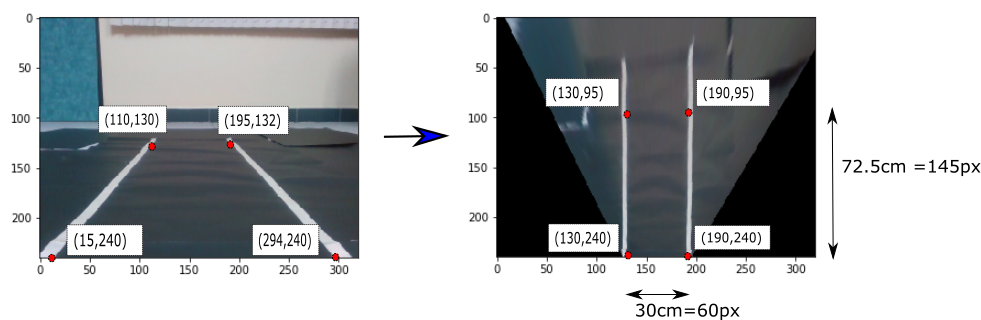

A continuación se presenta la parte del algoritmo que realiza esta tarea y se muestran las vistas aereas de la imagen original y la imagen binaria enmascarada obtenida anteriormente.

Text(0.5,1,u'Imagen binaria de ROI')

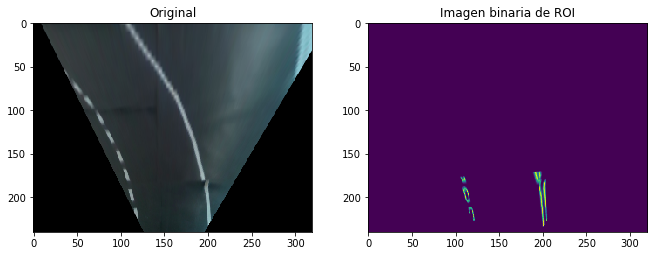

In [15]:
#puntos conocidos en la imagen original
pts1 = numpy.float32([[110,130],[195,132],[294,240],[15,240]])  
#puntos obtenidos apartir de imagen prueba junto con mediciones
pts2 = numpy.float32([[130,95],[190,95],[190,240],[130,240]])
#Matriz de trasnformación
M_n = cv2.getPerspectiveTransform(pts1,pts2)
### ESTA PARTE NO ES NECESARIA CALCULARLA EN CADA OCASION... ELIMINAR ESTO DEL CODIGO IMPLEMENTADO

#Transformacion de imagen binaria y original a vista de ave, cada pixel corresponde a .5cm aprox
binary_warped = cv2.warpPerspective(masked_image,M_n,(320,240))  
orig_warped = cv2.warpPerspective(cv_image,M_n,(320,240))

out_img = numpy.dstack((binary_warped, binary_warped, binary_warped))*255

plt.figure(figsize=(11,11))

plt.subplot(1,2,1)
plt.imshow(orig_warped)
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(binary_warped)
plt.title('Imagen binaria de ROI')



In [8]:
lane1, lane2 = Lane_functions.image_lanes(binary_warped)

[115, 115, 116, 119, 120]
[197, 198, 199, 200, 201, 202, 203, 204]


In [9]:
if   ((lane1 != []) and (lane2 != [])):
	state = 1
elif ((lane1 != []) and (lane2 == []) and (state==1) and (numpy.mean(lane1)>160)):
	state = 2
elif ((lane1 != []) and (lane2 == []) and (state==1) and (numpy.mean(lane1)<160)):
	state = 3
elif ((lane1 != []) and (lane2 == []) and (state==2) ):
	state = 2
elif ((lane1 != []) and (lane2 == []) and (state==3) ):
	state = 3
elif ((lane1 == []) and (lane2 == [])):
	state = 4
    
print(state)

1


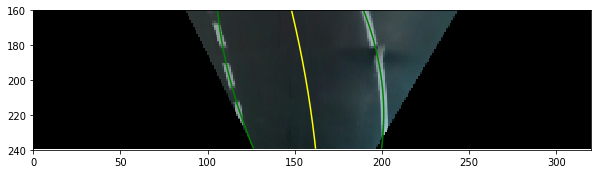

In [16]:
plt.figure(figsize=(10,10))
if state == 1:
	#Utilizar los dos carriles para detectar error lateral
	left_fit = Lane_functions.poly_for_lane(lane1,out_img)
	right_fit = Lane_functions.poly_for_lane(lane2,out_img)
	
	ploty = numpy.linspace(0,binary_warped.shape[0]-1, binary_warped.shape[0])
	left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
	right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]
	
	
	center_fit = Lane_functions.center_lane_f2(right_fitx,left_fitx,ploty)

	center_fitx = center_fit[0]*ploty**2+center_fit[1]*ploty+center_fit[2]


	plt.imshow(orig_warped)
	plt.plot(left_fitx, ploty, color='green')
	plt.plot(right_fitx, ploty, color='green')
	plt.plot(center_fitx, ploty, color='yellow')
	plt.xlim(0,320)
	plt.ylim(240,160)
	plt.show()


	
elif state == 2:
	#Utilizar un carril para detectar error lateral
	poly_fit = Lane_functions.poly_for_lane(lane1,out_img)
	ploty = numpy.linspace(0,binary_warped.shape[0]-1, binary_warped.shape[0])
	poly_fitx = poly_fit[0]*ploty**2+poly_fit[1]*ploty+poly_fit[2]

	center_fit =Lane_functions.center_lane_f1(poly_fitx,ploty,state)	
	center_fitx = center_fit[0]*ploty**2+center_fit[1]*ploty+center_fit[2]

	plt.imshow(orig_warped)
	plt.plot(poly_fitx, ploty, color='green')
	plt.plot(center_fitx, ploty, color='yellow')
	plt.xlim(0,320)
	plt.ylim(240,160)
	plt.show()
	
elif state == 3:
	#Utilizar un carril para detectar error lateral
	poly_fit = Lane_functions.poly_for_lane(lane1,out_img)
	ploty = np.linspace(0,binary_warped.shape[0]-1, binary_warped.shape[0])
	poly_fitx = poly_fit[0]*ploty**2+poly_fit[1]*ploty+poly_fit[2]

	center_fit = Lane_functions.center_lane_f1(poly_fitx,ploty,state)	
	center_fitx = center_fit[0]*ploty**2+center_fit[1]*ploty+center_fit[2]

	plt.imshow(orig_warped)
	plt.plot(poly_fitx, ploty, color='green')
	plt.plot(center_fitx, ploty, color='yellow')
	plt.xlim(0,320)
	plt.ylim(240,160)
	plt.show()

elif state == 4:
    print('no veo nada')